# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/noisy_port-80_percentage-0.0.pcap/result-lstm-tcp80-hl2-seq5-do0.2-oov1000-Monday-WorkingHours_testing_80.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.9-1048-208.185.118.105-80-tcp,0.156028,1,1,1,19068.660650,1,1,1
1,192.168.10.9-1057-69.31.33.224-80-tcp,0.268817,1,1,1,53818.181818,1,1,1
2,192.168.10.9-1064-184.26.44.97-80-tcp,0.233918,1,1,1,32499.279528,1,1,1
3,192.168.10.9-1065-208.185.118.105-80-tcp,0.147208,1,1,1,21035.255208,1,1,1
4,192.168.10.9-1066-208.185.118.89-80-tcp,0.156028,1,1,1,19068.660650,1,1,1


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,4,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80,192.168.10.5,49188,6,03/07/2017 08:55:58,1,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80,192.168.10.14,49486,6,03/07/2017 08:56:22,3,2,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


## Exploratory Data Analysis

In [5]:
df_truth[[' Label']].value_counts()

 Label
BENIGN    529918
Name: count, dtype: int64

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
1        29550
0         1844
Name: count, dtype: int64

In [7]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           29149
0            2245
Name: count, dtype: int64

In [8]:
df_truth.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [9]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 80
df_truth = df_truth[(df_truth['Source_Port'] == 80) | (df_truth['Destination_Port'] == 80)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69352 entries, 0 to 529901
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      69352 non-null  object 
 1   Source_IP                    69352 non-null  object 
 2   Source_Port                  69352 non-null  int64  
 3   Destination_IP               69352 non-null  object 
 4   Destination_Port             69352 non-null  int64  
 5   Protocol                     69352 non-null  int64  
 6   Timestamp                    69352 non-null  object 
 7   Flow_Duration                69352 non-null  int64  
 8   Total_Fwd_Packets            69352 non-null  int64  
 9   Total_Backward_Packets       69352 non-null  int64  
 10  Total_Length_of_Fwd_Packets  69352 non-null  float64
 11  Total_Length_of_Bwd_Packets  69352 non-null  float64
 12  Fwd_Packet_Length_Max        69352 non-null  float64
 13  Fwd_Packet_Length_Mi

In [10]:
df_truth['Label'].head()

0    BENIGN
1    BENIGN
2    BENIGN
3    BENIGN
4    BENIGN
Name: Label, dtype: object

In [11]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_347759/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [12]:
df_pred["id"]

0          192.168.10.9-1048-208.185.118.105-80-tcp
1             192.168.10.9-1057-69.31.33.224-80-tcp
2             192.168.10.9-1064-184.26.44.97-80-tcp
3          192.168.10.9-1065-208.185.118.105-80-tcp
4           192.168.10.9-1066-208.185.118.89-80-tcp
                            ...                    
31389       192.168.10.16-47010-172.217.7.14-80-tcp
31390       192.168.10.16-47384-172.217.7.14-80-tcp
31391    192.168.10.16-36708-202.123.106.106-80-tcp
31392      192.168.10.12-48028-104.16.28.216-80-tcp
31393       192.168.10.19-48301-23.61.187.27-80-tcp
Name: id, Length: 31394, dtype: object

In [13]:
df_truth["id"]

0            8.254.250.126-80-192.168.10.5-49188-tcp
1            8.254.250.126-80-192.168.10.5-49188-tcp
2            8.254.250.126-80-192.168.10.5-49188-tcp
3            8.254.250.126-80-192.168.10.5-49188-tcp
4           8.253.185.121-80-192.168.10.14-49486-tcp
                             ...                    
529866       54.192.36.97-80-192.168.10.16-34392-tcp
529884    192.229.173.173-80-192.168.10.25-51518-tcp
529890       192.168.10.17-54892-8.12.196.253-80-tcp
529900     151.101.20.249-80-192.168.10.17-53370-tcp
529901        68.67.178.199-80-192.168.10.9-1354-tcp
Name: id, Length: 69352, dtype: object

In [14]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [16]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label


In [17]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.9-1048-208.185.118.105-80-tcp,0.156028,1,1,1,19068.660650,1,1,1,0
1,192.168.10.9-1057-69.31.33.224-80-tcp,0.268817,1,1,1,53818.181818,1,1,1,0
2,192.168.10.9-1057-69.31.33.224-80-tcp,0.268817,1,1,1,53818.181818,1,1,1,0
3,192.168.10.9-1064-184.26.44.97-80-tcp,0.233918,1,1,1,32499.279528,1,1,1,0
4,192.168.10.9-1065-208.185.118.105-80-tcp,0.147208,1,1,1,21035.255208,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
63481,192.168.10.16-47010-172.217.7.14-80-tcp,0.140878,1,1,1,25302.857143,1,1,1,0
63482,192.168.10.16-47384-172.217.7.14-80-tcp,0.141531,1,1,1,25570.140845,1,1,1,0
63483,192.168.10.16-36708-202.123.106.106-80-tcp,0.164706,1,1,1,29046.164000,1,1,1,0
63484,192.168.10.12-48028-104.16.28.216-80-tcp,0.129103,1,1,1,23979.221239,1,1,1,0


In [18]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.9-1048-208.185.118.105-80-tcp,0.156028,1,1,1,19068.660650,1,1,1,0
1,192.168.10.9-1057-69.31.33.224-80-tcp,0.268817,1,1,1,53818.181818,1,1,1,0
2,192.168.10.9-1057-69.31.33.224-80-tcp,0.268817,1,1,1,53818.181818,1,1,1,0
3,192.168.10.9-1064-184.26.44.97-80-tcp,0.233918,1,1,1,32499.279528,1,1,1,0
4,192.168.10.9-1065-208.185.118.105-80-tcp,0.147208,1,1,1,21035.255208,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
63481,192.168.10.16-47010-172.217.7.14-80-tcp,0.140878,1,1,1,25302.857143,1,1,1,0
63482,192.168.10.16-47384-172.217.7.14-80-tcp,0.141531,1,1,1,25570.140845,1,1,1,0
63483,192.168.10.16-36708-202.123.106.106-80-tcp,0.164706,1,1,1,29046.164000,1,1,1,0
63484,192.168.10.12-48028-104.16.28.216-80-tcp,0.129103,1,1,1,23979.221239,1,1,1,0


In [19]:
df_pred[['Label']].value_counts()

Label
0        63486
Name: count, dtype: int64

In [20]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [21]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [22]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,1
4,1
...,...
63481,1
63482,1
63483,1
63484,1


### Detection Rate

In [23]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 0.0
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0
Recall-Floating-f_zscore: 0.0


/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/apta/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:15

### Confussion Matrix

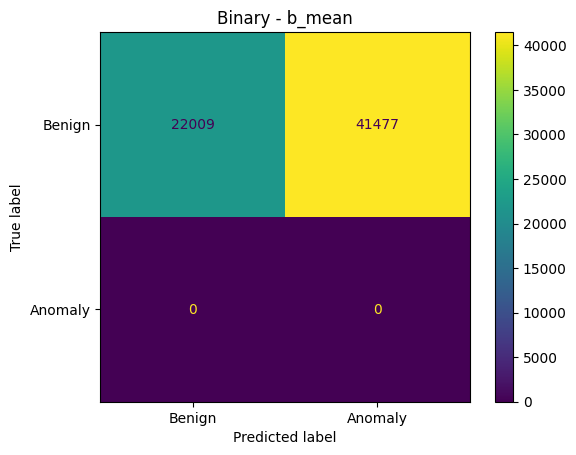

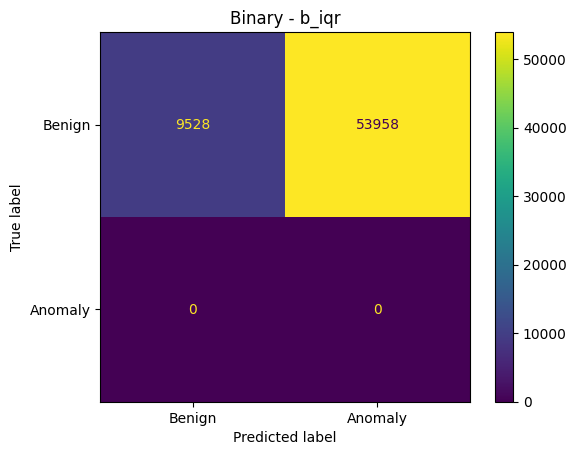

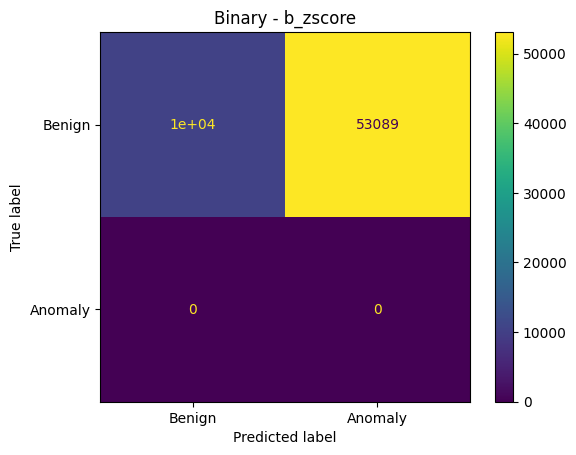

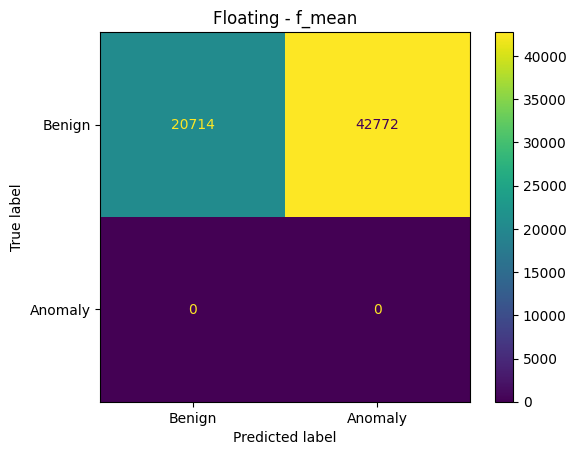

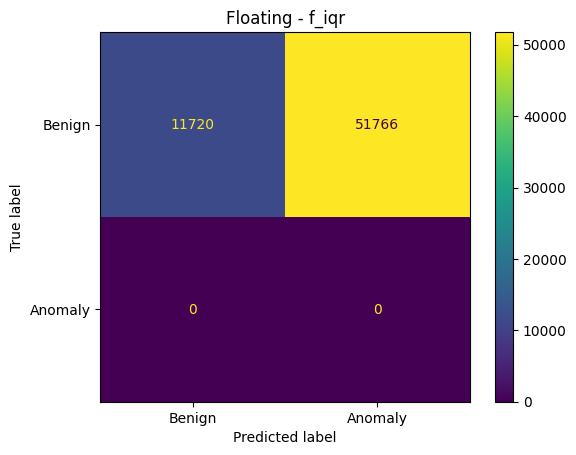

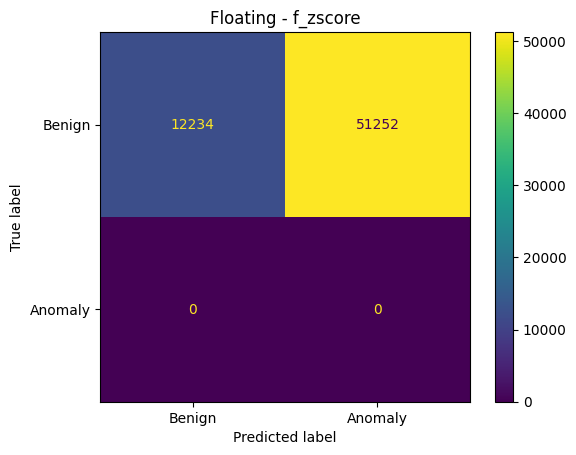

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [25]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.0
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.0
F2-Floating-f_zscore: 0.0


### FPR Score

In [26]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.6533251425511136
FPR-Binary-b_iqr: 0.8499196673282299
FPR-Binary-b_zscore: 0.8362316101187663
FPR-Floating-f_mean: 0.6737233405790253
FPR-Floating-f_iqr: 0.8153923699713322
FPR-Floating-f_zscore: 0.8072960967772422


In [27]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.3466748574488864
Accuracy-Binary-b_iqr: 0.15008033267177015
Accuracy-Binary-b_zscore: 0.16376838988123366
Accuracy-Floating-f_mean: 0.3262766594209747
Accuracy-Floating-f_iqr: 0.18460763002866773
Accuracy-Floating-f_zscore: 0.19270390322275777


In [28]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.0,0.0,0.653325,0.346675
b_iqr,0.0,0.0,0.849920,0.150080
b_zscore,0.0,0.0,0.836232,0.163768
f_mean,0.0,0.0,0.673723,0.326277
f_iqr,0.0,0.0,0.815392,0.184608
f_zscore,0.0,0.0,0.807296,0.192704


In [29]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [30]:
# %pip install openpyxl